In [95]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from pprint import pprint
import os

In [58]:
# Read the files
movies_metadata = pd.read_csv('movies_metadata.csv')

In [59]:
# Remove rows with dirty data
shitty_idx = []
for idx, row in movies_metadata.iterrows():
    if not row['id'].isdigit():
        shitty_idx.append(idx)
print(shitty_idx)
movies_metadata.drop(shitty_idx, axis=0, inplace=True)

[19730, 29503, 35587]


In [60]:
# Change the index type to int and remove duplicated
print(movies_metadata.shape)
movies_metadata['id'] = movies_metadata['id'].astype('int64')
movies_metadata.drop_duplicates(subset='id', inplace=True)
movies_metadata.set_index('id', inplace=True)
print(movies_metadata.shape)
print(movies_metadata.index)

(45463, 24)
(45433, 23)
Int64Index([   862,   8844,  15602,  31357,  11862,    949,  11860,  45325,
              9091,    710,
            ...
             84419, 390959, 289923, 222848,  30840, 439050, 111109,  67758,
            227506, 461257],
           dtype='int64', name='id', length=45433)


In [61]:
keywords = pd.read_csv('keywords.csv')
print(keywords.shape)
keywords.drop_duplicates(subset='id', inplace=True)
keywords.set_index('id', inplace=True)
print(keywords.shape)

(46419, 2)
(45432, 1)


In [62]:
credits = pd.read_csv('credits.csv')
print(credits.shape)
credits.drop_duplicates(subset='id', inplace=True)
credits.set_index('id', inplace=True)
print(credits.shape)

(45476, 3)
(45432, 2)


In [63]:
df = movies_metadata.join(keywords, how='inner').join(credits, how='inner')

In [64]:
print(movies_metadata.shape)
print(keywords.shape)
print(credits.shape)
print(df.shape)

(45433, 23)
(45432, 1)
(45432, 2)
(45432, 26)


In [65]:
df.head()

,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,keywords,cast,crew
id,,,,,,,,,,,,,,,,,,,,,
862,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
8844,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'id': 10090, 'name': 'board game'}, {'id': 1...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
15602,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392...","[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
31357,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'id': 818, 'name': 'based on novel'}, {'id':...","[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
11862,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...","[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [66]:
# Clean and transform some columns that comes with an array
parse_col = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages', 'cast', 'crew']
for column in parse_col:
    df[column] = df[column].fillna('[]').apply(literal_eval)
    df[column + '_cnt'] = df[column].map(len)
    print(colmn)
    print(df[column + '_cnt'].describe())
    print()

count    45432.000000
mean         2.003324
std          1.130698
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: genres_cnt, dtype: float64
count    45432.000000
mean         3.446954
std          4.690083
min          0.000000
25%          0.000000
50%          2.000000
75%          5.000000
max        149.000000
Name: keywords_cnt, dtype: float64
count    45432.000000
mean         1.086635
std          0.763007
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         25.000000
Name: production_countries_cnt, dtype: float64
count    45432.000000
mean         1.550977
std          1.741638
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         26.000000
Name: production_companies_cnt, dtype: float64
count    45432.000000
mean         1.172434
std          0.753488
min          0.000000
25%          1.000000
50%          1.000000
75

In [67]:
x = df.loc[8844, 'genres']
print(x)
print(type(x))
print(len(x))

[{'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {'id': 10751, 'name': 'Family'}]
<class 'list'>
3


In [21]:
# Take a look at the "array-like" columns by constructing different tables from them
def inspect_entities(e_name):
    entity_dict = {}
    for idx, row in df.iterrows():
        for g in row[e_name]:
            if g['id'] not in entity_dict:
                entity_dict[g['id']] = {'name': g['name'], 'count': 0}
            entity_dict[g['id']]['count'] += 1
    entity_df = pd.DataFrame(entity_dict).transpose()
    entity_df['count'] = entity_df['count'].astype('int')
    entity_df.sort_values('count', ascending=False, inplace=True)
    return entity_df

In [22]:
genres_df = inspect_entities('genres')
genres_df

,name,count
18,Drama,20244
35,Comedy,13176
53,Thriller,7619
10749,Romance,6730
28,Action,6592
27,Horror,4671
80,Crime,4304
99,Documentary,3930
12,Adventure,3490
878,Science Fiction,3044


In [41]:
# plt.hist(genres_df['count'], bins=50)
# plt.grid(True)
# plt.show()

In [27]:
keywords_df = inspect_entities('keywords')
keywords_df

,name,count
187056,woman director,3039
10183,independent film,1914
9826,murder,1285
818,based on novel,822
4344,musical,726
...,...,...
188607,rube,1
188606,middle america,1
166244,beatboxing,1
208126,crown jewels,1


<IPython.core.display.Javascript object>


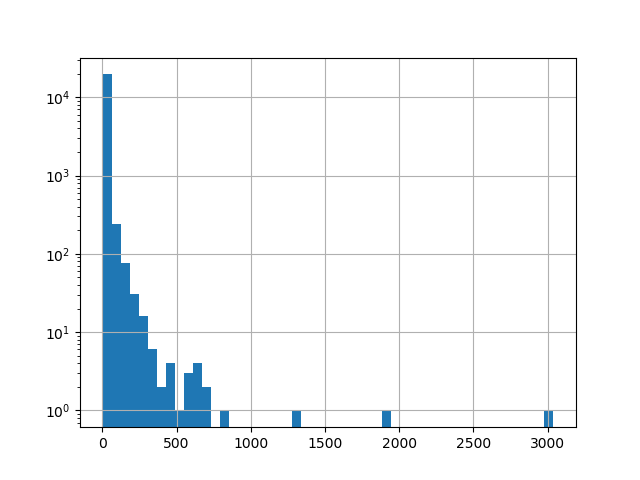

In [42]:
plt.hist(keywords_df['count'], bins=50, log=True)
plt.grid(True)
plt.show()

In [68]:
cast_df = inspect_entities('cast')
cast_df

,name,count
121323,Bess Flowers,241
113,Christopher Lee,148
4165,John Wayne,125
2231,Samuel L. Jackson,123
3895,Michael Caine,110
...,...,...
587632,Kim Mi-Kyung,1
587641,Sa-Hee,1
186018,Jack Elliott,1
1179594,Odetta,1


In [70]:
crew_df = inspect_entities('crew')
crew_df

,name,count
9062,Cedric Gibbons,272
2952,Avy Kaufman,184
4350,Edith Head,165
102429,Roger Corman,155
1259,Ennio Morricone,153
...,...,...
1782549,Vail Romeyn,1
1782548,Justin Haut,1
1782545,Adam Boor,1
1782543,Jamie Stires,1


In [71]:
prod_comp_df = inspect_entities('production_companies')
prod_comp_df

,name,count
6194,Warner Bros.,1250
8411,Metro-Goldwyn-Mayer (MGM),1074
4,Paramount Pictures,1001
306,Twentieth Century Fox Film Corporation,836
33,Universal Pictures,830
...,...,...
26338,Atrium Productions,1
21332,Eye Entertainment,1
64891,Ombadsman,1
618,Deutsche Filmvertriebs GmbH,1


In [72]:
df.to_csv('combined_dataframe.csv')

In [136]:
ratings_df = pd.read_csv('ratings.csv')

In [137]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [140]:
ratings_df.set_index('movieId', drop=False, append=True, inplace=True)

In [141]:
ratings_df[ratings_df['movieId'] == 27205]

,,userId,movieId,rating,timestamp
,movieId,,,,
3959442,27205,41190,27205,3.0,1275890695
4444634,27205,45811,27205,4.0,1455399770
19395887,27205,201372,27205,3.0,1310131491
21701284,27205,225396,27205,4.5,1275921784
23436635,27205,243331,27205,4.0,1275960427


## Sample and construct graphs

### 1. small graph with 10 top voted movies, and top 5 cast, and top 5 production companies

In [151]:
print(df['vote_count'].dtype)
top_voted = df.sort_values('vote_count', ascending=False).iloc[:10]
top_voted

float64


,adult,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,keywords,cast,crew,genres_cnt,keywords_cnt,production_countries_cnt,production_companies_cnt,spoken_languages_cnt,cast_cnt,crew_cnt
id,,,,,,,,,,,,,,,,,,,,,
27205,False,NaN,160000000,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",http://inceptionmovie.warnerbros.com/,tt1375666,en,Inception,"Cobb, a skilled thief who commits corporate es...",29.1081,...,"[{'id': 1014, 'name': 'loss of lover'}, {'id':...","[{'cast_id': 1, 'character': 'Dom Cobb', 'cred...","[{'credit_id': '56e8462cc3a368408400354c', 'de...",5,8,2,3,1,29,18
155,False,"{'id': 263, 'name': 'The Dark Knight Collectio...",185000000,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",http://thedarkknight.warnerbros.com/dvdsite/,tt0468569,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,123.167,...,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...","[{'cast_id': 35, 'character': 'Bruce Wayne / B...","[{'credit_id': '55a0eb4a925141296b0010f8', 'de...",4,19,2,5,2,134,81
19995,False,"{'id': 87096, 'name': 'Avatar Collection', 'po...",237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.avatarmovie.com/,tt0499549,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",185.071,...,"[{'id': 1463, 'name': 'culture clash'}, {'id':...","[{'cast_id': 242, 'character': 'Jake Sully', '...","[{'credit_id': '52fe48009251416c750aca23', 'de...",4,21,2,4,2,83,153
24428,False,"{'id': 86311, 'name': 'The Avengers Collection...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://marvel.com/avengers_movie/,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,89.8876,...,"[{'id': 242, 'name': 'new york'}, {'id': 5539,...","[{'cast_id': 46, 'character': 'Tony Stark / Ir...","[{'credit_id': '52fe4495c3a368484e02b1cf', 'de...",3,10,1,2,1,115,147
293660,False,"{'id': 448150, 'name': 'Deadpool Collection', ...",58000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.foxmovies.com/movies/deadpool,tt1431045,en,Deadpool,Deadpool tells the origin story of former Spec...,187.86,...,"[{'id': 2095, 'name': 'anti hero'}, {'id': 307...","[{'cast_id': 99, 'character': 'Wade Wilson / D...","[{'credit_id': '57e564fac3a3681beb0000cc', 'de...",3,9,1,5,1,46,88
157336,False,NaN,165000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 18, '...",http://www.interstellarmovie.net/,tt0816692,en,Interstellar,Interstellar chronicles the adventures of a gr...,32.2135,...,"[{'id': 83, 'name': 'saving the world'}, {'id'...","[{'cast_id': 9, 'character': 'Joseph Cooper', ...","[{'credit_id': '54cba75b925141678e014d1a', 'de...",3,31,3,5,1,36,120
68718,False,NaN,100000000,"[{'id': 18, 'name': 'Drama'}, {'id': 37, 'name...",http://unchainedmovie.com/,tt1853728,en,Django Unchained,"With the help of a German bounty hunter, a fre...",19.785,...,"[{'id': 801, 'name': 'bounty hunter'}, {'id': ...","[{'cast_id': 6, 'character': 'Django', 'credit...","[{'credit_id': '5703f6a2c3a36869850001d9', 'de...",2,21,1,2,3,115,88
118340,False,"{'id': 284433, 'name': 'Guardians of the Galax...",170000000,"[{'id': 28, 'name': 'Action'}, {'id': 878, 'na...",http://marvel.com/guardians,tt2015381,en,Guardians of the Galaxy,"Light years from Earth, 26 years after being a...",53.2916,...,"[{'id': 8828, 'name': 'marvel comic'}, {'id': ...","[{'cast_id': 1, 'character': 'Peter Quill / St...","[{'credit_id': '538ce329c3a3687155003358', 'de...",3,9,2,4,1,80,105
550,False,NaN,63000000,"[{'id': 18, 'name': 'Drama'}]",http://www.foxmovies.com/movies/fight-club,tt0137523,en,Fight Club,A ticking-time-bomb insomniac and a slippery s...,63.8696,...,"[{'id': 825, 'name': 'support group'}, {'id': ...","[{'cast_id': 4, 'character': 'The Narrator', '...","[{'credit_id': '55731b8192514111610027d7', 'de...",1,7,2,7,1,77,107


In [152]:
def create_nodes_and_edges(df, output_dir, include_node_types, limits, with_ratings=None):
    # Write the dataframe to disk for backup
    top_voted.to_csv(os.path.join(output_dir, 'dataframe.csv'))
    
    # Mapping from original id in the data table to the index in the nodes array
    # We need to use a new index system because the original ids are separated for different entities
    movie_mapping = {}
    other_type_mapping = []
    for i in range(len(include_node_types)):
        other_type_mapping.append({})
    if with_ratings:
        other_type_mapping.append({})
        
    edges = []
    nodes = []
    
    for movie_id, m in top_voted.iterrows():
        nodes.append({'original_id': movie_id, 'label': m['original_title'], 'type': 'movie'})
        movie_mapping[movie_id] = len(nodes) - 1

        for type_idx, t in enumerate(include_node_types):
            # assuming it is an array 
            column_array = m[t][:limits[type_idx]] if limits[type_idx] > 0 else m[t]
            for c in column_array:
                if c['id'] not in other_type_mapping[type_idx]:
                    nodes.append({'original_id': c['id'], 'label': c['name'], 'type': t})
                    other_type_mapping[type_idx][c['id']] = len(nodes) - 1
                edges.append({
                    'source': movie_mapping[movie_id], 
                    'target': other_type_mapping[type_idx][c['id']], 
                    'weight': 1.0
                })
                
        if with_ratings:
            for rid, r in ratings_df[ratings_df['movieId'] == movie_id].iloc[:with_ratings].iterrows():
                if r['userId'] not in other_type_mapping[-1]:
                    nodes.append({'original_id': int(r['userId']), 'label': '', 'type': 'user'})
                    other_type_mapping[-1][r['userId']] = len(nodes) - 1
                edges.append({
                    'source': movie_mapping[movie_id], 
                    'target': other_type_mapping[-1][r['userId']], 
                    'weight': r['rating']
                })

    print(len(nodes), len(edges))
    # Construct dataframes to emit
    nodes_df = pd.DataFrame(nodes)
    edges_df = pd.DataFrame(edges)
    nodes_df.to_csv(os.path.join(output_dir, 'nodes.csv'), index_label='node_index')
    edges_df.to_csv(os.path.join(output_dir, 'edges.csv'), index_label='edge_index')
    
    return nodes_df, edges_df

In [153]:
nodes_df, edges_df = create_nodes_and_edges(top_voted, './graphs/small-10-movies/', 
                                            ['cast', 'production_companies'], [5, 5])

84 87


In [154]:
nodes_df

,original_id,label,type
0,27205,Inception,movie
1,6193,Leonardo DiCaprio,cast
2,24045,Joseph Gordon-Levitt,cast
3,27578,Ellen Page,cast
4,2524,Tom Hardy,cast
...,...,...,...
79,96066,Liam Hemsworth,cast
80,57755,Woody Harrelson,cast
81,9281,Elizabeth Banks,cast
82,1632,Lionsgate,production_companies


In [155]:
edges_df

,source,target,weight
0,0,1,1.0
1,0,2,1.0
2,0,3,1.0
3,0,4,1.0
4,0,5,1.0
...,...,...,...
82,76,79,1.0
83,76,80,1.0
84,76,81,1.0
85,76,82,1.0


### 2. medium-sized graph with 20 top voted movies, and top 5 cast,  top 3 production companies, genres, and keywords

In [156]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:20]
nodes_df, edges_df = create_nodes_and_edges(top_voted, './graphs/medium-20-movies/', 
                                            ['cast', 'production_companies', 'genres', 'keywords'], [5, 5, -1, -1])

404 536


### 3. medium-sized graph with 20 top voted movies, and top 5 cast,  top 3 production companies, genres, and 20 user ratings

In [157]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:20]
nodes_df, edges_df = create_nodes_and_edges(top_voted, './graphs/medium-20-movies-with-ratings/', 
                                            ['cast', 'production_companies', 'genres'], [5, 5, -1], 20)

298 379


### 4. large graph with 100 top voted movies, and top 10 cast,  top 3 production companies, genres, and 30 user ratings

In [159]:
top_voted = df.sort_values('vote_count', ascending=False).iloc[:100]
nodes_df, edges_df = create_nodes_and_edges(top_voted, './graphs/large-100-movies-with-ratings/', 
                                            ['cast', 'production_companies', 'genres'], [10, 5, -1], 30)

1815 2797
